# Almost entirely Quantum algorithm for MaxCut problem

## MaxCut Problem 


Let there be an undirected graph G. Vertices of graph G have two colors blue and red for example. A bond between two vertices is considerd to be cut if it connects vertices of different colors . 

Consider that each bond has a weight wi. The MaxCut problem involves finding the cuts such that the sum of cut weights of will be the maximum value.

$$ C = \sum_{l}w_{l}. $$ 
$$w_{l}-cut weight$$ 

 In [1a] and [1c] a solution of these problems using VQE is well presented. Here we use another quantum approach to this problem. We use the FQE (Full Quantum Eigensolver) presented in paper [2]. The key of FQE is quantum gradient descended. Create with the help of duality quantum computing, see [3]



Let’s begin:

## Cost function and Hamiltonian

If we choose a color 1 and another one 0 we can write C in the form:

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

Next step is to introduce C into a quantum computer. To do this we use the substitution underneath:
 $Z-i$ is a pauli z on the i qbit and identity on another. Now C looks like this


$$x_i\rightarrow (1-Z_i)/2$$

$$C(\textbf{Z}) = \sum_{i,j} \frac{w_{ij}}{4} (1-Z_i)(1+Z_j) =-1/2\sum_{i<j} w_{i,j} Z_iZ_j+k $$
 

Here k is a constant part of C obtained by calculating the product between the identities and w. It is obvious that in order for C to be maximum H needs to be minimum, where H is:

$$(*) H = \sum_{i<j} w_{i,j} Z_iZ_j $$

Following up H will be our main element in solving the problem

## Gateaux-Derivative

An important step in gradient descendant is obviously calculating the gradient. 
Here X is a vector and H a matrix that satisfies all conditions .

$$ 𝑓(X)=X^⊤HX $$


$$ 𝑓(X,εδX)=(X+εδX)^⊤H(X+εδX)
=X^⊤HX+ε(δX)^⊤HX+εX^⊤𝑅(δX)+ε^2(δX)^⊤H(δX) $$

$$ \frac{d}{dε}𝑓(X,εδX)=(δX)^⊤HX+X^⊤H(δX)+2ε(δX)^⊤H(δX) $$


At the limit when ε->0 :

$$ \frac{d}{dε}𝑓(X,εδX)=(δX)^⊤HX+X^⊤H(δX) $$

$$ \frac{d}{dε}𝑓(X,εδX)=2(δX)^⊤HX $$

$$ ∇𝑓(X)=2HX $$

# Quantum Gradient descendent

General case:

$|X^t>$ trprezent input state of X

$|X^{t+1}>$ trprezent X after 1 itteration

$$ X^{(t+1) }=X^t −y_0∇𝑓( X )$$

$$ |X^{(t+1)}>=|X^t>-2y_0H|X^t>=(1-2y_0H)|X^t>$$

$$ |X^{(t+1)}>=H^g|X^t>   $$

$$H^g=(1-2y_0H)$$

from $(*)$ :
$$(**)  H^g=(1-2y_0\sum_{i<j} w_{i,j} Z_iZ_j ) $$

To implement $H^g$ we will use a technical present in [3] and [2] we will use some auxiliary qubits (Y) . First we need to decompouze $H^g$ in simple operators  :

$$H^g=\sum_{i=0}^{m-1}β_iH_i^g$$

Compare with $(**)$:
$ H_0^g=1; β_0=1$

$H_1^g=Z_0Z_1; β_1=w_{0,1}$

$H_2^g=Z_0Z_2; β_2=w_{0,2}$

$...$

m- number of esy to compute operator . 

State of Y must be :

$$Y=\frac{1}{C}\sum_{i=0}^{m-1}β_i|i> $$  

C- is a constant used to norm state Y at the unit $C=(\sum_{i=0}^{m-1}β_i^2)^{(1/2)}$

i-nr in basis 10  of qbits in Y  ex : |1>=|001> , |4>=|110>

Next we apply control $H_i^g$ in such way tat $H_i^g$  will be applied to X onlye if Y is in state i and state of our cicuit becomes:

$$\frac{1}{C}\sum_{i=0}^{m-1}β_i|i>H_i^g|X^t>$$

Now we apply Hadamamard gate on entire Y which recombines our states (in such wey that for$ Y=0): |X>=|X^{t+1}>$  and measure . 

Observation: We only have some chance to compute  $X^{t+1}$ so we need to take multiple shots in order to construct new useful states ( $X^{t+1}$)

After measurement we are interested only in the state where Y=0 . We need to extract $ X^{t+1}$ and reapply gradient descendent on them to find  $X^{t+2 } $and repeat all the steps until we have a constant answer or reach the maximum number of iterations (in the last case we will play with  $y_0$ before deciding to try a new technique).

# Short example

Here we treat a simple 3 vertices graph. In the picture below are all the math operations step by step:

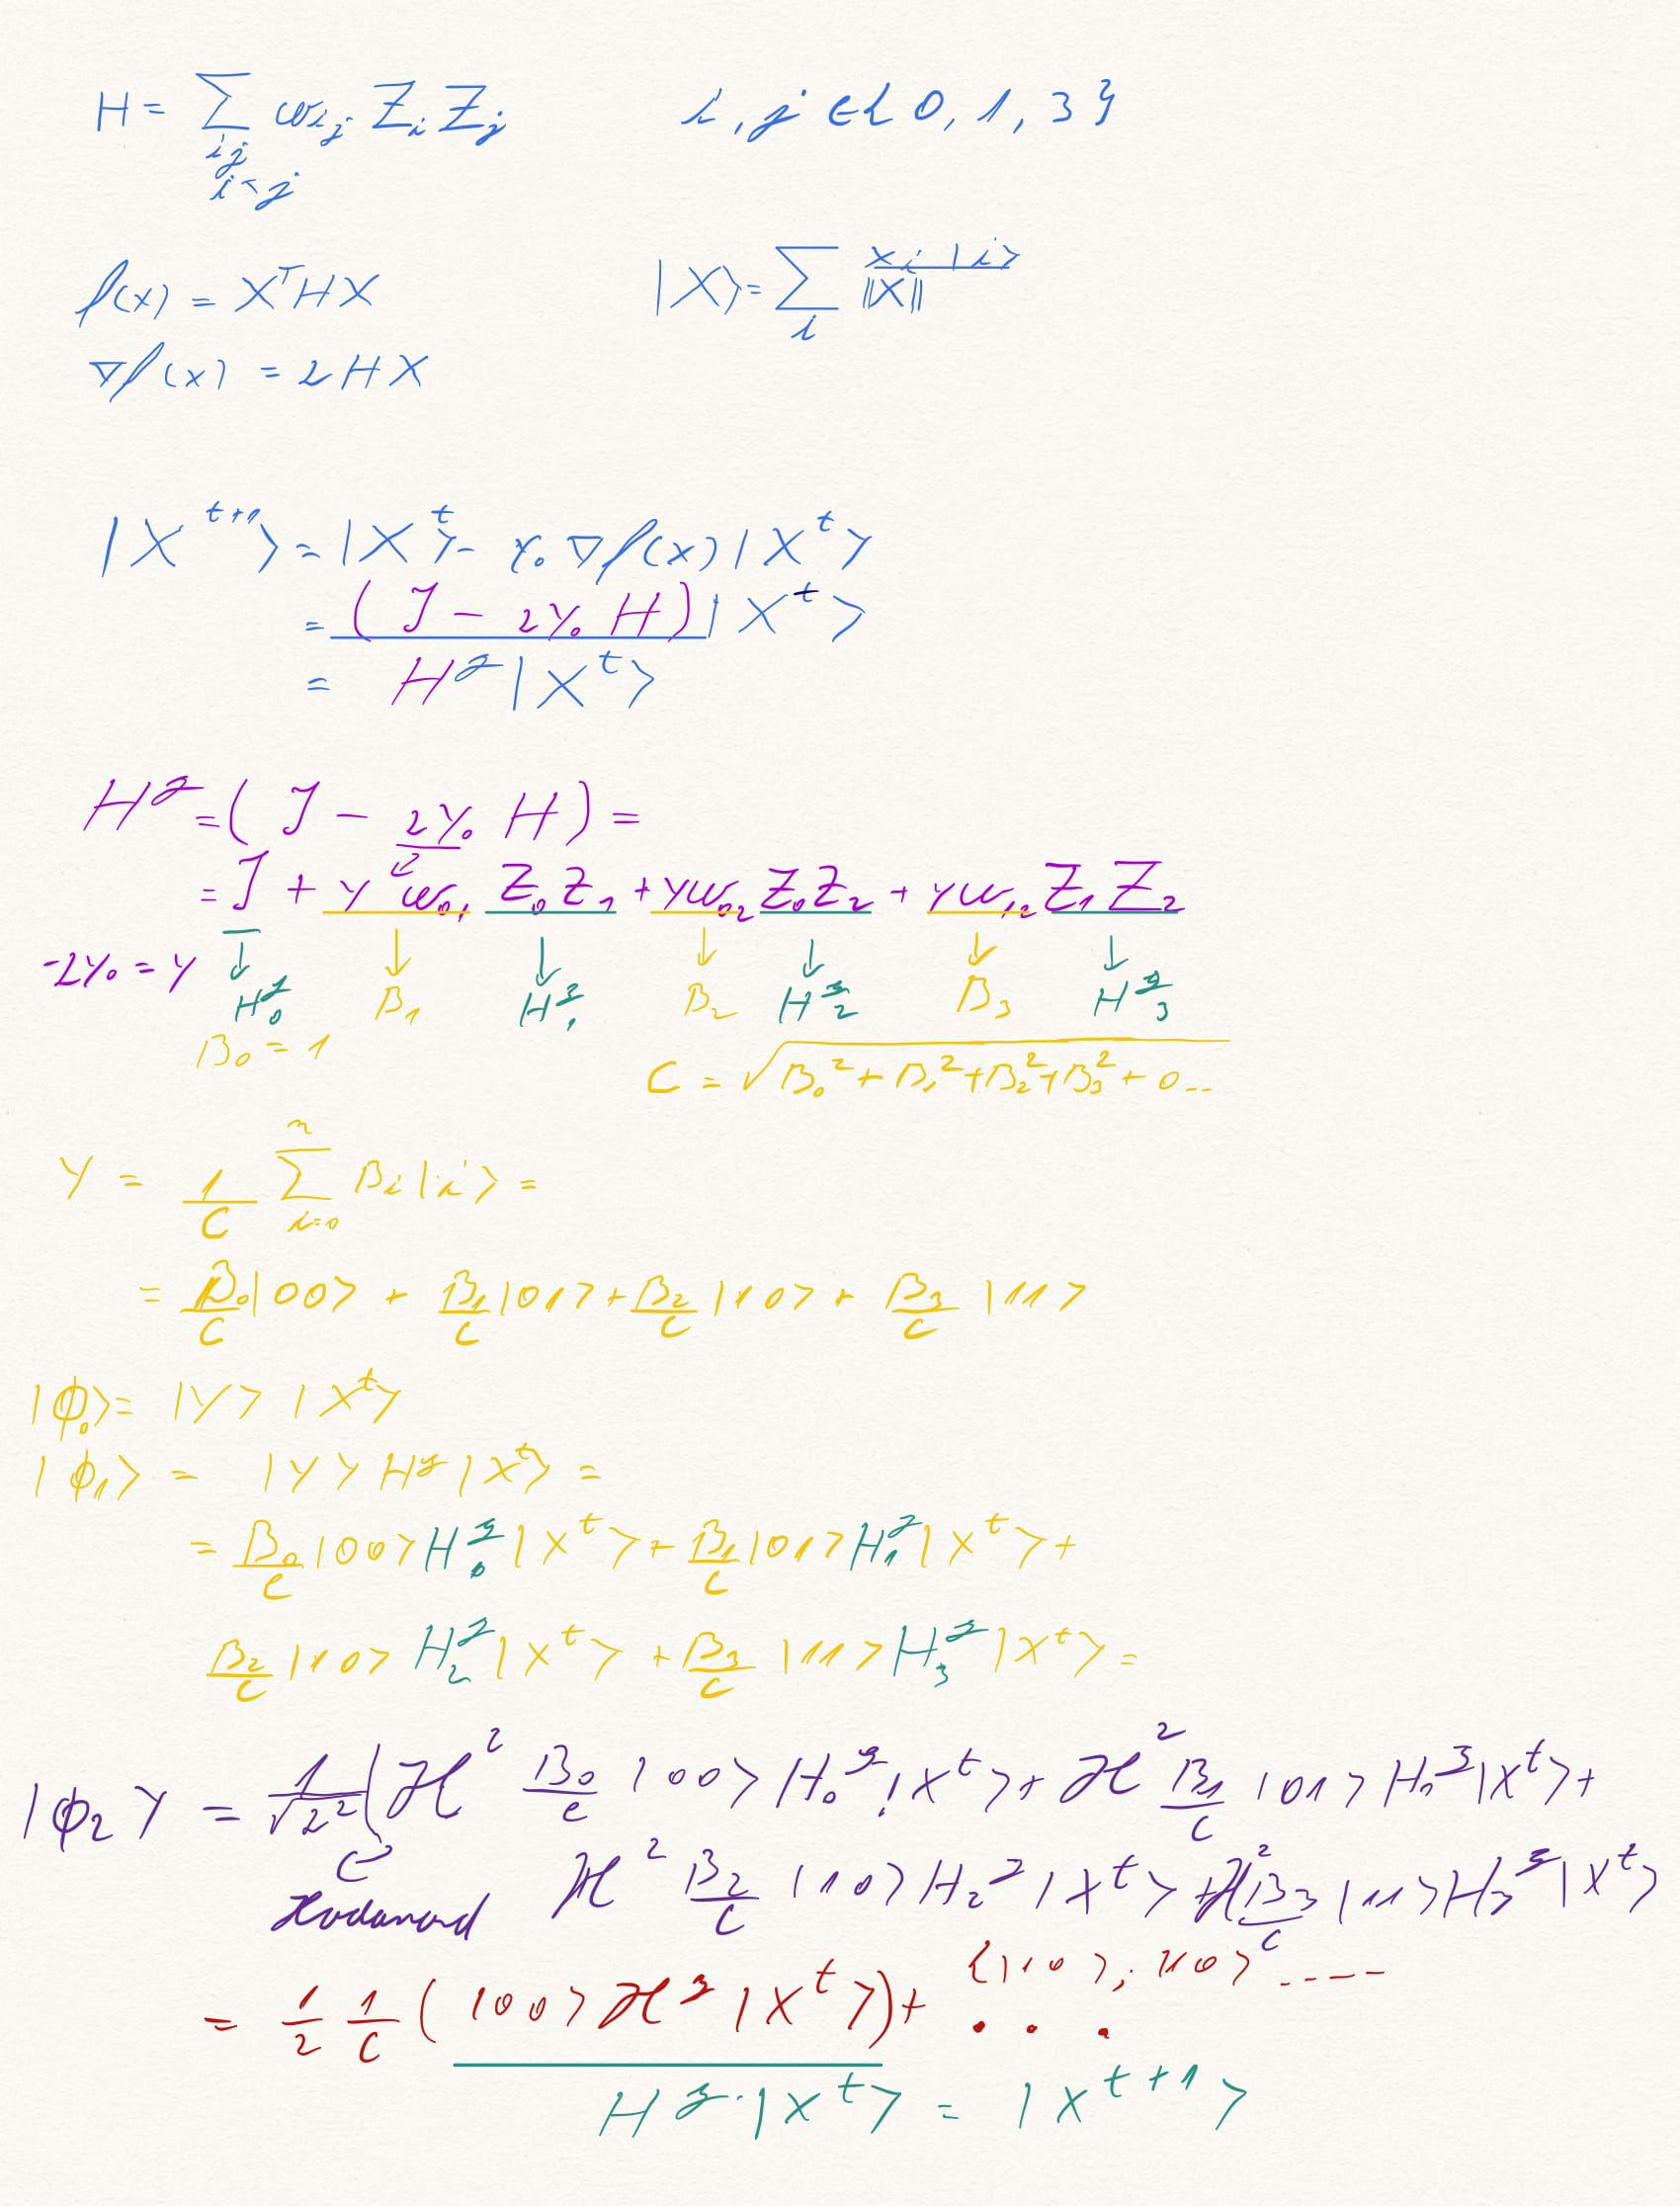

In [19]:
from IPython.display import Image
Image("bitOfMath.jpg")

In [68]:
import  numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import networkx as nx

from qiskit import IBMQ,BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit,ClassicalRegister,QuantumRegister,execute

from qiskit.tools.visualization import plot_histogram

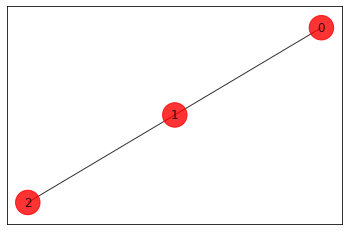

In [234]:
#Create the graph to be cut 

n=3 #nr nodes
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(2,1,1.0),(1,0,1.0)]#list with conected  node and  coresponding weight(1,0,1.0)]
G.add_weighted_edges_from(elist)

colors=['r' for node in G.nodes()]
pos=nx.spring_layout(G)
default_axes=plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors,node_size=600,alpha=.8,ax=default_axes,pos=pos)


In [235]:
#compute the weight matrix

w=np.zeros([n,n])
for i in range (n):
    for j in range(n):
        temp=G.get_edge_data(i,j,default=0)
        if temp!=0:
            w[i,j]=temp['weight']
print(w)

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


case=[0, 0, 0] cost= 0.0
case=[1, 0, 0] cost= 1.0
case=[0, 1, 0] cost= 2.0
case=[1, 1, 0] cost= 1.0
case=[0, 0, 1] cost= 1.0
case=[1, 0, 1] cost= 2.0
case=[0, 1, 1] cost= 1.0
case=[1, 1, 1] cost= 0.0

Best solution = [1, 0, 1] cost = 2.0


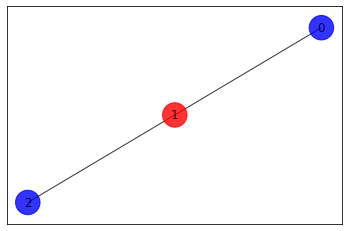

In [236]:
#brut force  for verification  :

best_cost_brute=0
for b in range(2**n):
    x=[int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost=0
    for i in range(n):
        for j in range(n):
            cost=cost+w[i,j]*x[i]*(1-x[j])
            
    if best_cost_brute<=cost:
        best_cost_brute=cost
        xbest_brute=x
            
    print('case='+str(x)+' cost=',str(cost))
    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))  

In [237]:
#compute Y,X 

sizeY=0
for i in range(n):
    sizeY=sizeY+i
    
sizeY=2**int(math.log(sizeY,2))*2  
print('sizeY='+str(sizeY))

sizeY=int(sizeY)
Y=np.zeros(sizeY)
print(Y)
y0=1
y=-2*y0

C=0
k=1
for i in range (n):
    for j in range (i):
        Y[k]=w[i,j]
        C=C+Y[k]*Y[k]*y*y
        k+=1
        #print(str(j)+' '+str(i)) #useful wey yo see conection betwen nodes for me 
        
C=math.sqrt(C)    
for i in range(sizeY):
    Y[i]=Y[i]*y/C

X=[1/math.sqrt(2**n) for i in range(2**n)]  

print(Y)
print(X)

sizeY=4
[0. 0. 0. 0.]
[-0.         -0.70710678 -0.         -0.70710678]
[0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373]


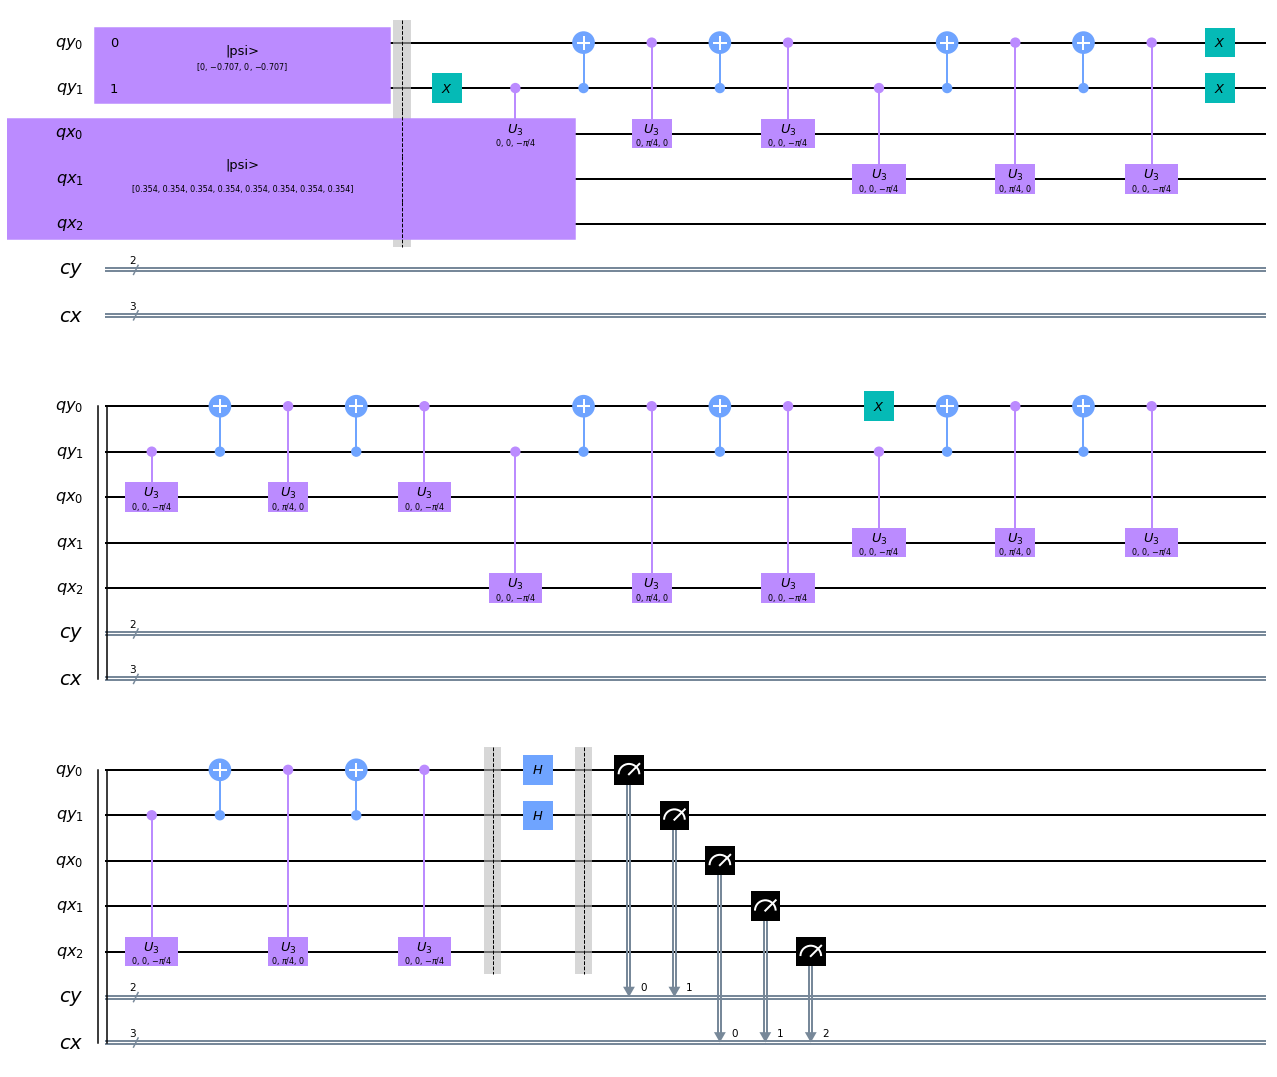

In [238]:
#build circuit for  these particular exmple  

def Gcirc3(n,m,stateVectorY,stateVectorX):
    
    qx=QuantumRegister(n,'qx')
    cx=ClassicalRegister(n,'cx')

    qy=QuantumRegister(m,'qy')
    cy=ClassicalRegister(m,'cy')

    qc=QuantumCircuit(qy,qx,cy,cx) 

    qc.initialize(stateVectorY,qy)
    qc.initialize(stateVectorX,qx)

    qc.barrier()


    lam=-np.pi/2 # because we want Z Pauli 

    #01
    qc.x(qy[1]) #we need to have state 01 to aply Z matrices 
    qc.mcrz( lam, qy, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy, qx[1], use_basis_gates=False)
    qc.x(qy[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy[0])
    qc.mcrz( lam, qy, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy, qx[2], use_basis_gates=False)
    qc.x(qy[0])

    #12
    qc.mcrz( lam, qy, qx[1], use_basis_gates=False)
    qc.mcrz( lam, qy, qx[2], use_basis_gates=False)


    qc.barrier()
    for i in range(m):
        qc.h(qy[i])

    qc.barrier()
    qc.measure(range(n+m), range(n+m))
    qc.draw(output="mpl")
    return qc

qc=Gcirc3(3,2,Y,X)
qc.draw(output="mpl")

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

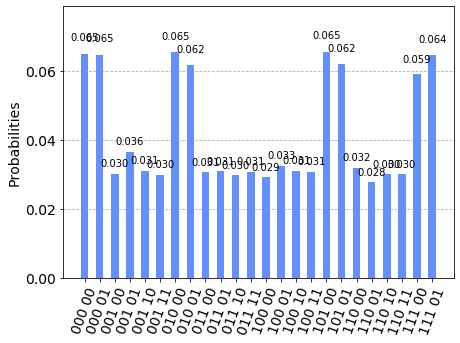

In [239]:
#run circuit to extract X^(t+1)
    
backend = BasicAer.get_backend('qasm_simulator')
shot = 9000
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

In [240]:
print(counts) #see how counts dictionary look like 

{'100 01': 293, '011 00': 275, '001 10': 279, '001 01': 328, '110 11': 270, '101 01': 558, '101 00': 589, '100 00': 263, '000 01': 581, '111 00': 530, '010 01': 555, '100 11': 277, '100 10': 280, '110 10': 270, '001 11': 269, '010 00': 587, '111 01': 580, '000 00': 584, '011 11': 277, '001 00': 272, '011 01': 278, '011 10': 268, '110 00': 287, '110 01': 250}


In [241]:
#recreate X statevector  
#remeber we are interested onlie in state with Y=|00>

#Definetly need a more efficient wey but for didactic porpouse is god enought
if '000 00' in counts:
    X[0]=counts['000 00']
else:
    X[0]=0
if '001 00' in counts:
    X[1]=counts['001 00']
else:
    X[1]=0
if '010 00' in counts:
    X[2]=counts['010 00']
else:
    X[2]=0
if '011 00' in counts:
    X[3]=counts['011 00']
else:
    X[3]=0
if '100 00' in counts:
    X[4]=counts['100 00']
else:
    X[4]=0
if '101 00' in counts:
    X[5]=counts['101 00']
else:
    X[5]=0
if '110 00' in counts:
    X[6]=counts['110 00']
else:
    X[6]=0
if '111 00' in counts:
    X[7]=counts['111 00']
else:
    X[7]=0

C=0
for i in range(2**n):
    C=C+X[i]*X[i]
    
C=math.sqrt(C) 
for i in range(2**n):
    X[i]=X[i]/C

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

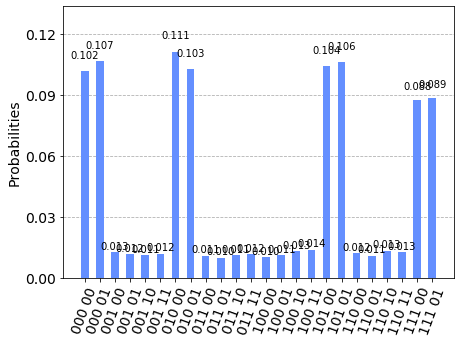

In [242]:
#compute next step :
qc=Gcirc3(3,2,Y,X)
backend = BasicAer.get_backend('qasm_simulator')
shot = 7000
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

Let's see how our state evolve step by step:

In [243]:
#recreate X statevector 
if '000 00' in counts:
    X[0]=counts['000 00']
else:
    X[0]=0
if '001 00' in counts:
    X[1]=counts['001 00']
else:
    X[1]=0
if '010 00' in counts:
    X[2]=counts['010 00']
else:
    X[2]=0
if '011 00' in counts:
    X[3]=counts['011 00']
else:
    X[3]=0
if '100 00' in counts:
    X[4]=counts['100 00']
else:
    X[4]=0
if '101 00' in counts:
    X[5]=counts['101 00']
else:
    X[5]=0
if '110 00' in counts:
    X[6]=counts['110 00']
else:
    X[6]=0
if '111 00' in counts:
    X[7]=counts['111 00']
else:
    X[7]=0

C=0
for i in range(2**n):
    C=C+X[i]*X[i]
    
C=math.sqrt(C) 
for i in range(2**n):
    X[i]=X[i]/C

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

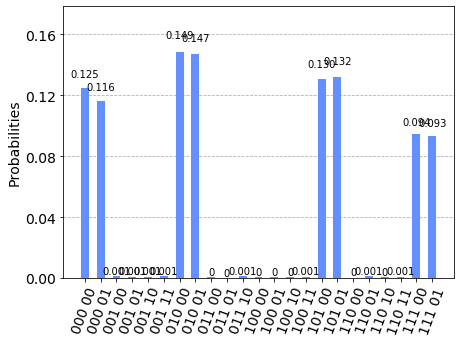

In [244]:
qc=Gcirc3(3,2,Y,X)
backend = BasicAer.get_backend('qasm_simulator')
shot = 7000
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

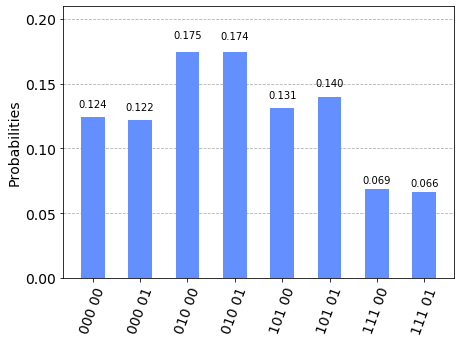

In [245]:
#recreate X statevector 
if '000 00' in counts:
    X[0]=counts['000 00']
else:
    X[0]=0
if '001 00' in counts:
    X[1]=counts['001 00']
else:
    X[1]=0
if '010 00' in counts:
    X[2]=counts['010 00']
else:
    X[2]=0
if '011 00' in counts:
    X[3]=counts['011 00']
else:
    X[3]=0
if '100 00' in counts:
    X[4]=counts['100 00']
else:
    X[4]=0
if '101 00' in counts:
    X[5]=counts['101 00']
else:
    X[5]=0
if '110 00' in counts:
    X[6]=counts['110 00']
else:
    X[6]=0
if '111 00' in counts:
    X[7]=counts['111 00']
else:
    X[7]=0

C=0
for i in range(2**n):
    C=C+X[i]*X[i]
    
C=math.sqrt(C) 
for i in range(2**n):
    X[i]=X[i]/C
    
qc=Gcirc3(3,2,Y,X)
backend = BasicAer.get_backend('qasm_simulator')
shot = 7000
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

In [246]:
#not necesar because we can run the cel above multiple time
for i in range(15):
    #recreate X statevector 
    if '000 00' in counts:
        X[0]=counts['000 00']
    else:
        X[0]=0
    if '001 00' in counts:
        X[1]=counts['001 00']
    else:
        X[1]=0
    if '010 00' in counts:
        X[2]=counts['010 00']
    else:
        X[2]=0
    if '011 00' in counts:
        X[3]=counts['011 00']
    else:
        X[3]=0
    if '100 00' in counts:
        X[4]=counts['100 00']
    else:
        X[4]=0
    if '101 00' in counts:
        X[5]=counts['101 00']
    else:
        X[5]=0
    if '110 00' in counts:
        X[6]=counts['110 00']
    else:
        X[6]=0
    if '111 00' in counts:
        X[7]=counts['111 00']
    else:
        X[7]=0

    C=0
    for i in range(2**n):
        C=C+X[i]*X[i]

    C=math.sqrt(C) 
    for i in range(2**n):
        X[i]=X[i]/C

    qc=Gcirc3(3,2,Y,X)
    backend = BasicAer.get_backend('qasm_simulator')
    shot = 7000
    results= execute(qc,backend=backend,shots=shot).result()
    counts=results.get_counts(qc)
    plot_histogram(counts)

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

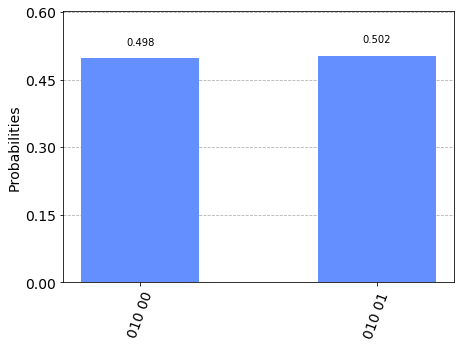

In [247]:
plot_histogram(counts)

Ieey, we finally find a good enough X with the middle node colored in another color!

# References !

Captivating lecture:

[1a]MaxCut: https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747

[1b]MaxCut: https://en.wikipedia.org/wiki/Maximum_cut

[1c]MaxCut: https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aqua/optimization/max_cut_and_tsp.ipynb

[2]FQE: https://doi.org/10.34133/2020/1486935

[3]Duality quantum computer :	arXiv:1507.03200

[4]Gateaux derivative :https://en.wikipedia.org/wiki/Gateaux_derivative
        